# Predição Inadimplência Cartão de Crédito

## Descrição dos dados

* *X1:* Quanto foi dado de crédito em dólar (individual e família) (montante de crédito concedido)
* *X2:* Gênero -> 1 = Masculino, 2 = Feminino
* *X3:* Educação -> 1 = Pós-Graduação, 2 = Universidade, 3 = Ensino Médio, 4 = Outros
* *X4:* Estado Civil -> 1 = Casado, 2 = Solteiro, 3 = Outros
* *X5:* Idade
* *X6 - X11:* Histórico de Pagamentos -> X6 = Setembro à X11 = Abril (PAY_...)
    * -1: Pagou devidamente
    *  1: Pagou com atraso de um mês
    *  2: Pagou com atraso de dois meses
    *  3: Pagou com atraso de três meses
    ...
    
* *X12 - X17:* Quantia de declaração de conta -> X12 = Setembro à X17 = Abril (BILL_AMT_...)
* *X18 -> X23:* Montante do pagamento anterior -> X18 = Setembro à X23 = Abril (PAY_AMT_...)
* *X24:* Se a pessoa pagou, variável de interesse

In [1]:
import pandas as pd
import numpy as np

df = pd.read_excel('default of credit card clients.xls')
df = df.iloc[1:]

# Drop records with minimum data
df['X3'].replace(0, np.nan, inplace=True)
df['X4'].replace(0, np.nan, inplace=True)
df.dropna(inplace=True, subset=['X3', 'X4'])

# # Substitute discrete values - Median
# for i in range(6, 12):
#     x_idx = f'X{str(i)}'
    
#     df[x_idx].replace(0, np.nan, inplace=True)
#     df[x_idx].fillna(df[x_idx].median(skipna=True), inplace=True)
    
# Substitute discrete values - Mode
for i in range(6, 12):
    x_idx = f'X{str(i)}'
    
    np_array = df[x_idx].values
    mode = pd.Series(np_array[np_array != 0]).mode()[0]
    
    df[x_idx].replace(0, np.nan, inplace=True)
    df[x_idx].fillna(mode, inplace=True)

# Substitute real values
for i in range(12, 24):
    x_idx = f'X{str(i)}'
    sum_value = pd.to_numeric(df[x_idx], errors='coerce').sum()
    amount = len(df[x_idx].nonzero()[0])
    mean = sum_value/amount
    
    df[x_idx].replace(0, mean, inplace=True)

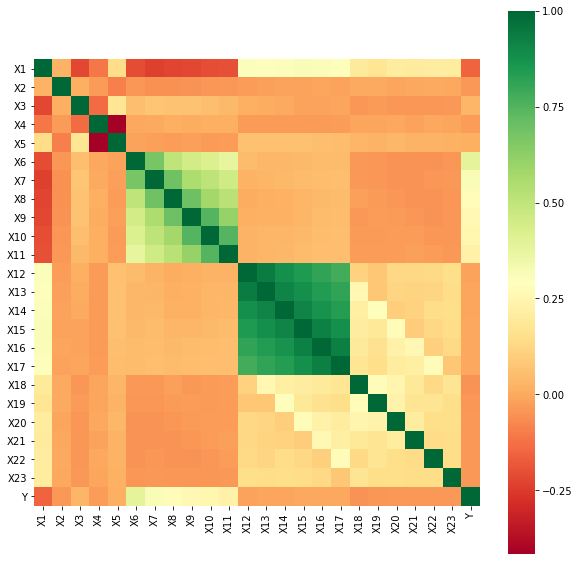

In [5]:
# Heatmap
import seaborn as sns
from matplotlib import pyplot

df = df.astype(float)

pyplot.figure(figsize=(10, 10))
sns.heatmap(df.corr(), square=True, cmap='RdYlGn')

pyplot.show()

In [3]:
# Split training data and test data
from sklearn.model_selection import train_test_split

data = df.iloc[:, [x for x in range(23)]]
target = df.iloc[:, [23]]

X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.33, random_state=42, stratify=target)

In [4]:
# Using KNN mathematical model to calculate performance.
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

knn.score(X_test, y_test)

/home/vinicius/mlEnv/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  after removing the cwd from sys.path.


0.7686778700141729